# Reinforcement Learning pour le Yams

## Objectifs

Développer un environnement de jeu pour le Yams et entraîner un algorithme de renforcement pour jouer au Yams.

## Réprésentation des figures

Chaque type de figure (Nombre, Pair/Brelan/Carré/Yams,...) est représenté par une classe qui permet de définir si avec une combinaison de dès (représentation par histogramme), il est possible de réaliser la figure et le nombre de point qu'elle rapporte le cas échéant.

```python
class Number():
    def __init__(self, number:int):
        self.number = number

    def is_valid(self, dices:np.array):
        return dices[self.number] > 0

    def compute_value(self, dices:np.array):
        return (self.number + 1) * dices[self.number]

# Number(2) compte le nombre de 3 parmis les dès
print(Number(2).compute_value(np.array([0, 3, 2, 0, 0, 0])))
```

## Environnement de tour

L'environnement de tour est identique à l'environnement donné. Le vecteur de récompense est déterminé en prenant la figure disponible qui rapporte le plus de point pour chaque combinaison de dés.

## Politique du Tour

Plusieurs choix de politique du tour sont possibles. Pour des raisons de performances, on utilise une politique `greedy`, c'est-à-dire la value function dépend de la reward maximal associé à chaque état terminal.

$$V_{\pi_{turn}}(s) = max_{s,a}(r_{(s, a)})$$ 
où $r_{(s, a)}$ est la reward associé à la décision d'effectuer l'action $a$ dans l'état $s$ au sein de l'environnnement du Yams.

A partir de cet reward on peut calculer la policy en utilisant les equations de Bellman.

$$\pi(s) = argmax_a \sum_{s',r} p(s',r|s,a)[r + \gamma V\pi(s')]$$

Ce choix de politique est justifié par un besoin de performances et la possibilité de précalculé la politique pour chaque état $s$ du jeu de Yams.

Un meilleur choix serait d'utiliser $\pi_{Yams}$ pour le jeu de Yams afin d'obtenir $V_{\pi_{turn}}$.


## Environnement de partie

### Environnement fiche de score binaire
Les états sont représenté par un vecteur binaire indiquant si la figure a été prise ou non durant la partie.

Si l'on considère les règles de Yams suivantes:

    - 3 dès à 3 faces
    - Figures: Somme des dès à 1, 2 et 3 faces et le Brelan

$(0,0,0,0)$ est `l'état initial`

$(1, 1, 1,1)$ est `l'état terminal`

Une action $a$ est représenté par un entier $i$ qui correspond à l'ensemble des indices des cases non cochés dans l'état courant $s$

La récompense associé à $(s, a)$ dépend du lancer de dès obtenue dans l'environnement de tour.

Le nombre d'états est $|S| = 2^{nb\_figures}$

### Environnement fiche de score binaire avec somme des récompenses
Les états sont représenté par un vecteur binaire indiquant si la figure a été prise ou non durant la partie accompagné de la somme des récompenses obtenues précédemment.

Si l'on considère les règles de Yams suivantes:

    - 3 dès à 3 faces
    - Figures: Somme des dès à 1, 2 et 3 faces et le Brelan

$([0,0,0,0], 0)$ est `l'état initial`

$([1, 1, 1, 1], r_{total})$ est `l'état terminal`

Une action $a$ est représenté par un tuple entier $(i, r)$ qui correspond à la case à coché d'indice $i$ et la récompense $r$ associée à écrire dans la case.

La récompense $r$ associé à $(s, a)$ dépend du lancer de dès obtenue dans l'environnement de tour.

Le nombre d'états est borné par $|S| \leq 2^{nb\_figures} \times r_{totalmax}$

## Politique du Yams

La politique du Yams permet de décider quelle case doit être coché à chaque tour de jeu afin de maximiser le score globale du jeu

On comparera trois algorithmes vues en cours :
- `First visit MC prediction`
- `SARSA`
- `Q-Learning`

Toutes les implémentations utilisent une politique epsilon-greedy pour gérer l'exploration de l'espace d'états

Afin d'évaluer les politique obtenue, on les compare entre elles et avec la `politique aléatoire` et la `politique greedy`

### Test sur l'environnement avec somme des récompenses

100%|██████████| 50000/50000 [00:42<00:00, 1170.52it/s]


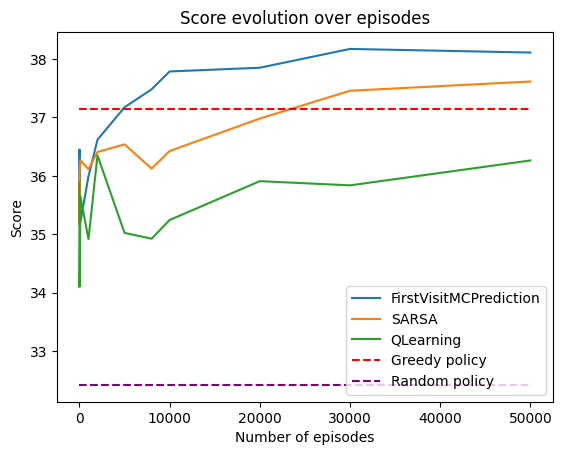

In [3]:
from algo import FirstVisitMCPrediction, SARSA, QLearning
from yams_env import YamsEnvBinary, YamsEnvTotal
from figures import *
import numpy as np
import matplotlib.pyplot as plt
from yams_env import random_policy, default_RL_policy

rlalgo1 = FirstVisitMCPrediction(epsilon=1.0, gamma=1.0)
rlalgo2 = SARSA(epsilon=1.0, gamma=1.0, alpha=0.2)
rlalgo3 = QLearning(epsilon=1.0, gamma=1.0, alpha=0.2)
figures = [Multiple(3, 15), Multiple(2, 5), Number(0), Number(1), Number(2), Chance()]
n_episodes = 50000
test_episodes = [0, 1, 10, 100, 1000, 2000, 5000, 8000, 9999, 20000, 30000, 49999]
env = YamsEnvTotal(3, 3, figures)

env.RL_policy = rlalgo1.choose_action
test_scores = rlalgo1.fit(env, max_iter=n_episodes, seed=1, test_episodes=test_episodes)
env.RL_policy = rlalgo2.choose_action
test_scores2 = rlalgo2.fit(env, max_iter=n_episodes, seed=1, test_episodes=test_episodes)
env.RL_policy = rlalgo3.choose_action
test_scores3 = rlalgo3.fit(env, max_iter=n_episodes, seed=1, test_episodes=test_episodes)
env.RL_policy = default_RL_policy
n_test_episodes = 1000
test_scores4 = rlalgo1.test(env, n_test_episodes)
env.RL_policy = random_policy
test_scores5 = rlalgo1.test(env, n_test_episodes)

plt.plot(test_episodes, np.mean(test_scores, axis=1), label='FirstVisitMCPrediction')
plt.plot(test_episodes, np.mean(test_scores2, axis=1), label='SARSA')
plt.plot(test_episodes, np.mean(test_scores3, axis=1), label='QLearning')
plt.hlines(np.mean(test_scores4), 0, n_episodes, label='Greedy policy', linestyles='dashed', color='red')
plt.hlines(np.mean(test_scores5), 0, n_episodes, label='Random policy', linestyles='dashed', color='purple')
plt.legend()
plt.xlabel('Number of episodes')
plt.ylabel('Score')
plt.title('Score evolution over episodes')
plt.show()


### Test sur l'environnement binaire

100%|██████████| 50000/50000 [00:41<00:00, 1215.88it/s]


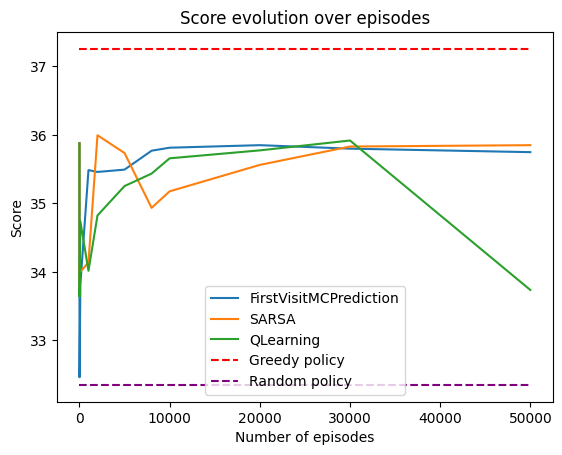

In [ ]:
rlalgo1 = FirstVisitMCPrediction(epsilon=1.0, gamma=1.0)
rlalgo2 = SARSA(epsilon=1.0, gamma=1.0, alpha=0.2)
rlalgo3 = QLearning(epsilon=1.0, gamma=1.0, alpha=0.2)
figures = [Multiple(3, 15), Multiple(2, 5), Number(0), Number(1), Number(2), Chance()]
n_episodes = 50000
test_episodes = [0, 1, 10, 100, 1000, 2000, 5000, 8000, 9999, 20000, 30000, 49999]
env = YamsEnvBinary(3, 3, figures)

env.RL_policy = rlalgo1.choose_action
test_scores = rlalgo1.fit(env, max_iter=n_episodes, seed=1, test_episodes=test_episodes)
env.RL_policy = rlalgo2.choose_action
test_scores2 = rlalgo2.fit(env, max_iter=n_episodes, seed=1, test_episodes=test_episodes)
env.RL_policy = rlalgo3.choose_action
test_scores3 = rlalgo3.fit(env, max_iter=n_episodes, seed=1, test_episodes=test_episodes)
env.RL_policy = default_RL_policy
n_test_episodes = 1000
test_scores4 = rlalgo1.test(env, n_test_episodes)
env.RL_policy = random_policy
test_scores5 = rlalgo1.test(env, n_test_episodes)

plt.plot(test_episodes, np.mean(test_scores, axis=1), label='FirstVisitMCPrediction')
plt.plot(test_episodes, np.mean(test_scores2, axis=1), label='SARSA')
plt.plot(test_episodes, np.mean(test_scores3, axis=1), label='QLearning')
plt.hlines(np.mean(test_scores4), 0, n_episodes, label='Greedy policy', linestyles='dashed', color='red')
plt.hlines(np.mean(test_scores5), 0, n_episodes, label='Random policy', linestyles='dashed', color='purple')
plt.legend()
plt.xlabel('Number of episodes')
plt.ylabel('Score')
plt.title('Score evolution over episodes')
plt.show()


On remarque que l'environnement avec somme des récompense (env S) permet d'apprendre une politique meilleur que la politique greedy.

En revanche, l'environnement binaire (env B) ne permet pas d'apprendre des politiques meilleurs que la politique Greedy. En effet, la représentation des états dans l'environnement binaire n'inclut pas la récompense $r$ attendue lorsque l'on prend une action. 


Par exemple, si l'on se place au début de la partie de Yams (fiche de score:$(0,0,0,0)$) et si l'on considère deux résultats de lancers de dès:
- Cas 1 : [1] [1] [1]
- Cas 2 : [1] [2] [3]

Dans le cas 1, prendre la somme des 1 donne 3
Dans le cas 2, prendre la somme des 1 donne 1

Q[s, a] = Q[(0, 0, 0, 0), 0]

`L'action-value` est la même pour les deux lancés de dès alors qu'ils sont très différents.

